In [334]:

from datetime import datetime
import time

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn import metrics
from sklearn.preprocessing import RobustScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

import autosklearn.classification

from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor

import matplotlib.pyplot as plt
import seaborn as sns


In [335]:
df = pd.read_csv('../data/ordens_case_dnc_.csv', index_col='id')


In [336]:
df.head(2)

,price,order_date,due_date,opt_date,delivery_date,cidade_origem_id,regiao_origem_id,cidade_destino_id,regiao_destino_id,peso
id,,,,,,,,,,
0,107.78,2022-02-25 20:46:25+00:00,2022-03-02 00:00:00,2022-02-28 20:35:20,2022-03-02 18:03:33,2,1,25,1,23.8
1,7.47,2022-02-23 20:34:59+00:00,2022-02-24 00:00:00,2022-02-24 09:56:23,2022-02-24 15:52:40,2,1,16,4,536.0


In [337]:
df['order_date'] = df['order_date'].str[:-6]

In [338]:
df.head(2)


,price,order_date,due_date,opt_date,delivery_date,cidade_origem_id,regiao_origem_id,cidade_destino_id,regiao_destino_id,peso
id,,,,,,,,,,
0,107.78,2022-02-25 20:46:25,2022-03-02 00:00:00,2022-02-28 20:35:20,2022-03-02 18:03:33,2,1,25,1,23.8
1,7.47,2022-02-23 20:34:59,2022-02-24 00:00:00,2022-02-24 09:56:23,2022-02-24 15:52:40,2,1,16,4,536.0


In [339]:
def getTimeSeconds(x):
    d = datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
    return int(time.mktime(d.timetuple()))


df['order_date'] = df['order_date'].apply(getTimeSeconds)
df['due_date'] = df['due_date'].apply(getTimeSeconds)
df['opt_date'] = df['opt_date'].apply(getTimeSeconds)
df['delivery_date'] = df['delivery_date'].apply(getTimeSeconds)


In [340]:
len(df[df['opt_date'] < df['order_date']])


24

In [341]:
df = df[df['opt_date'] >= df['order_date']]


In [342]:
len(df[df['opt_date'] < df['order_date']])


0

In [343]:
df['post_time'] = df['opt_date'] - df['order_date']
df['elapsed_time'] = df['delivery_date'] - df['opt_date']


In [344]:
df.head(3)


,price,order_date,due_date,opt_date,delivery_date,cidade_origem_id,regiao_origem_id,cidade_destino_id,regiao_destino_id,peso,post_time,elapsed_time
id,,,,,,,,,,,,
0,107.78,1645832785,1646190000,1646091320,1646255013,2,1,25,1,23.8,258535,163693
1,7.47,1645659299,1645671600,1645707383,1645728760,2,1,16,4,536.0,48084,21377
3,5.98,1644514477,1645066800,1645094869,1645118592,2,1,21,1,441.0,580392,23723


In [345]:
df['outcome'] = 0
df['outcome'].iloc[df['due_date'] <= df['delivery_date']] = 1


/tmp/ipykernel_20049/1026693437.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['outcome'].iloc[df['due_date'] <= df['delivery_date']] = 1


In [346]:
df['outcome'].value_counts()

1    1234
0     537
Name: outcome, dtype: int64

In [347]:
df.head(3)

,price,order_date,due_date,opt_date,delivery_date,cidade_origem_id,regiao_origem_id,cidade_destino_id,regiao_destino_id,peso,post_time,elapsed_time,outcome
id,,,,,,,,,,,,,
0,107.78,1645832785,1646190000,1646091320,1646255013,2,1,25,1,23.8,258535,163693,1
1,7.47,1645659299,1645671600,1645707383,1645728760,2,1,16,4,536.0,48084,21377,1
3,5.98,1644514477,1645066800,1645094869,1645118592,2,1,21,1,441.0,580392,23723,1


In [348]:
df["cidade_origem_id"] = df["cidade_origem_id"].astype("category")
df["regiao_origem_id"] = df["regiao_origem_id"].astype("category")
df["cidade_destino_id"] = df["cidade_destino_id"].astype("category")
df["regiao_destino_id"] = df["regiao_destino_id"].astype("category")


In [349]:
df.dtypes

price                 float64
order_date              int64
due_date                int64
opt_date                int64
delivery_date           int64
cidade_origem_id     category
regiao_origem_id     category
cidade_destino_id    category
regiao_destino_id    category
peso                  float64
post_time               int64
elapsed_time            int64
outcome                 int64
dtype: object

<AxesSubplot:ylabel='Frequency'>

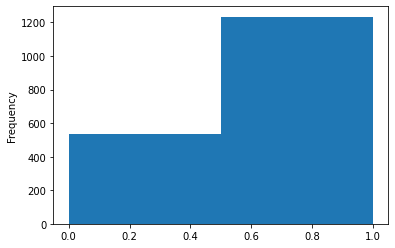

In [350]:
df['outcome'].plot.hist(bins=2)


<AxesSubplot:>

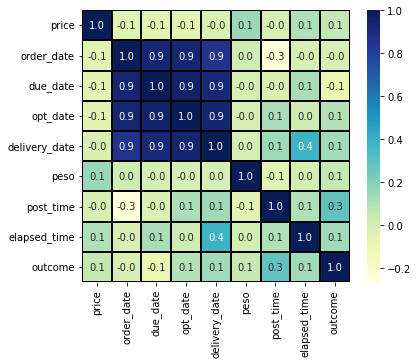

In [351]:
corr = df.corr()

plt.subplots(figsize=(6, 5))
sns.heatmap(corr, cmap='YlGnBu', annot=True, fmt=".1f",
            linecolor="black", linewidths="0.1", )


In [352]:
vif_data = pd.DataFrame()
vif_data["feature"] = df.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df.values, i)
                   for i in range(len(df.columns))]

vif_data

/home/felipe/dev/predicao-falha-entrega-logistica/venv/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,price,1.139275
1,order_date,inf
2,due_date,21.946690
3,opt_date,inf
4,delivery_date,inf
5,cidade_origem_id,9.550134
6,regiao_origem_id,11.665396
7,cidade_destino_id,1.193633
8,regiao_destino_id,1.133119
9,peso,1.054088


In [353]:
df.drop(columns=['order_date', 'due_date', 'opt_date', 'delivery_date', 'regiao_origem_id',
        'regiao_destino_id'], inplace=True)


<AxesSubplot:>

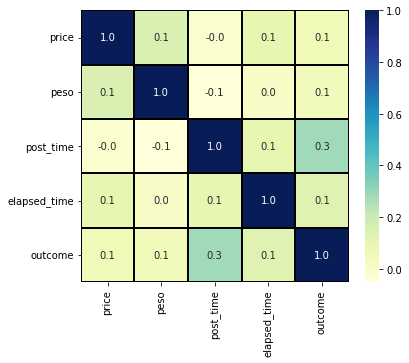

In [354]:
corr = df.corr()

plt.subplots(figsize=(6, 5))
sns.heatmap(corr, cmap='YlGnBu', annot=True, fmt=".1f",
            linecolor="black", linewidths="0.1", )


In [355]:
vif_data = pd.DataFrame()
vif_data["feature"] = df.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df.values, i)
                   for i in range(len(df.columns))]

vif_data


,feature,VIF
0,price,1.446526
1,cidade_origem_id,3.203289
2,cidade_destino_id,2.085958
3,peso,1.090828
4,post_time,2.223420
5,elapsed_time,1.393292
6,outcome,2.869556


In [356]:
dummy_df = pd.get_dummies(df[['cidade_origem_id',
                          'cidade_destino_id']], drop_first=True)
df = df.join(dummy_df)
df.drop(columns=['cidade_origem_id', 'cidade_destino_id'], inplace=True)


In [357]:
df.head()

,price,peso,post_time,elapsed_time,outcome,cidade_origem_id_2,cidade_origem_id_3,cidade_origem_id_4,cidade_origem_id_5,cidade_destino_id_2,...,cidade_destino_id_118,cidade_destino_id_119,cidade_destino_id_120,cidade_destino_id_121,cidade_destino_id_122,cidade_destino_id_123,cidade_destino_id_124,cidade_destino_id_125,cidade_destino_id_126,cidade_destino_id_127
id,,,,,,,,,,,,,,,,,,,,,
0,107.78,23.80,258535,163693,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7.47,536.00,48084,21377,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5.98,441.00,580392,23723,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,5.37,0.73,39753,21553,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7.47,875.00,45465,26751,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [358]:
X = df.drop(['outcome'], axis=1)
y = df['outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

X_train = pd.DataFrame(X_train, columns=X_train.columns)
y_train = pd.Series(y_train)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x


In [359]:
from imblearn.over_sampling import SMOTE


In [360]:
def trataDados(df_dados, target):
    # Balanceamento dos dados
    sm = SMOTE(sampling_strategy='minority', random_state=7)
    #   Fit the model to generate the data.
    df_dados, target = sm.fit_resample(df_dados, target)

    # Normalização dos dados
    df_dados[['price', 'peso', 'post_time', 'elapsed_time']] = RobustScaler(
    ).fit_transform(df_dados[['price', 'peso', 'post_time', 'elapsed_time']]).copy()

    return df_dados, target


X_train, y_train = trataDados(X_train, y_train)
X_val, y_val = trataDados(X_val, y_val)
X_test, y_test = trataDados(X_test, y_test)


In [361]:
X_train.head()


,price,peso,post_time,elapsed_time,cidade_origem_id_2,cidade_origem_id_3,cidade_origem_id_4,cidade_origem_id_5,cidade_destino_id_2,cidade_destino_id_3,...,cidade_destino_id_118,cidade_destino_id_119,cidade_destino_id_120,cidade_destino_id_121,cidade_destino_id_122,cidade_destino_id_123,cidade_destino_id_124,cidade_destino_id_125,cidade_destino_id_126,cidade_destino_id_127
0,-0.575758,0.813647,-0.367710,0.453470,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.357576,-0.019408,-0.082900,-2.116727,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.357576,0.743955,-0.129859,-1.657634,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.575758,0.837887,0.202454,-0.286182,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.357576,-0.018923,1.878039,-1.290676,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [362]:
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=100,
    per_run_time_limit=20)


In [363]:
automl.fit(X_train, y_train)


/home/felipe/dev/predicao-falha-entrega-logistica/venv/lib/python3.8/site-packages/autosklearn/metalearning/metalearning/meta_base.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.metafeatures = self.metafeatures.append(metafeatures)
/home/felipe/dev/predicao-falha-entrega-logistica/venv/lib/python3.8/site-packages/autosklearn/metalearning/metalearning/meta_base.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.algorithm_runs[metric].append(runs)


F1 Score: 89.84%
Accuracy Score: 89.88%
Precision Score: 85.56%
Recall Score: 95.95%


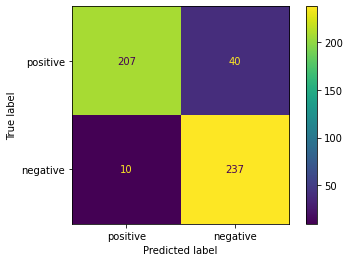

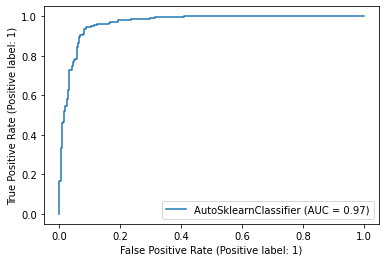

In [ ]:
predictAutoML = automl.predict(X_val)

f1 = round(f1_score(y_val, predictAutoML, average='macro')*100, 2)
accuracy = round(accuracy_score(y_val, predictAutoML)*100, 2)
precision = round(precision_score(y_val, predictAutoML)*100, 2)
recall = round(recall_score(y_val, predictAutoML)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

plot_confusion_matrix(automl, X_val, y_val, display_labels=[
                      "positive", "negative"], values_format="d")
plt.grid(False)
plt.show()

metrics.plot_roc_curve(automl, X_val, y_val)
plt.show()


F1 Score: 91.14%
Accuracy Score: 91.15%
Precision Score: 88.46%
Recall Score: 94.65%


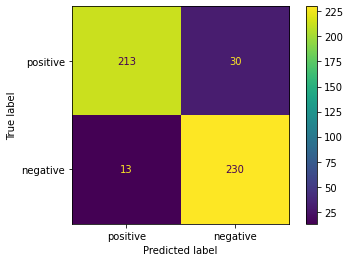

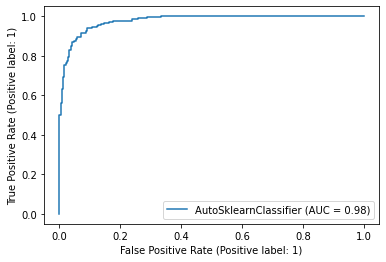

In [ ]:
predictAutoML = automl.predict(X_test)

f1 = round(f1_score(y_test, predictAutoML, average='macro')*100, 2)
accuracy = round(accuracy_score(y_test, predictAutoML)*100, 2)
precision = round(precision_score(y_test, predictAutoML)*100, 2)
recall = round(recall_score(y_test, predictAutoML)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

plot_confusion_matrix(automl, X_test, y_test, display_labels=[
                      "positive", "negative"], values_format="d")
plt.grid(False)
plt.show()

metrics.plot_roc_curve(automl, X_test, y_test)
plt.show()


In [ ]:
pd.DataFrame(automl.show_models()).transpose()


,model_id,rank,cost,ensemble_weight,data_preprocessor,balancing,feature_preprocessor,classifier,sklearn_classifier
2,2,1,0.067073,0.1,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(DecisionTreeClassifier(max_features=10, rando..."
25,25,2,0.069106,0.08,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(DecisionTreeClassifier(max_features=8, min_sa..."
3,3,3,0.077236,0.04,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(DecisionTreeClassifier(criterion='entropy', m..."
13,13,4,0.087398,0.06,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(DecisionTreeClassifier(max_features=2, min_sa..."
5,5,5,0.093496,0.02,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"KNeighborsClassifier(n_neighbors=6, p=1, weigh..."
16,16,6,0.093496,0.06,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(ExtraTreeClassifier(max_features=10, min_samp..."
20,20,7,0.093496,0.04,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"MLPClassifier(activation='tanh', alpha=0.00021..."
24,24,8,0.103659,0.14,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(DecisionTreeClassifier(max_depth=3, random_st..."
22,22,9,0.105691,0.06,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"MLPClassifier(alpha=0.02847755502162456, beta_..."
23,23,10,0.136179,0.02,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"MLPClassifier(activation='tanh', alpha=2.55502..."


In [ ]:
dtc_model = DecisionTreeClassifier()
knn_model = KNeighborsRegressor(3)
mlp_model = MLPClassifier(hidden_layer_sizes=(6, 5),
                    random_state=5,
                    verbose=True,
                    learning_rate_init=0.01)


In [ ]:
predict_DTC = dtc_model.predict(X_val)

f1 = round(f1_score(y_val, predict_DTC, average='macro')*100, 2)
accuracy = round(accuracy_score(y_val, predict_DTC)*100, 2)
precision = round(precision_score(y_val, predict_DTC)*100, 2)
recall = round(recall_score(y_val, predict_DTC)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

plot_confusion_matrix(predict_DTC, X_val, y_val, display_labels=[
                      "normal", "churn"], values_format="d")
plt.grid(False)
plt.show()

metrics.plot_roc_curve(predict_DTC, X_val, y_val)
plt.show()


In [ ]:
predict_KNN = knn_model.predict(X_val)

f1 = round(f1_score(y_val, predict_KNN, average='macro')*100, 2)
accuracy = round(accuracy_score(y_val, predict_KNN)*100, 2)
precision = round(precision_score(y_val, predict_KNN)*100, 2)
recall = round(recall_score(y_val, predict_KNN)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

plot_confusion_matrix(predict_KNN, X_val, y_val, display_labels=[
                      "normal", "churn"], values_format="d")
plt.grid(False)
plt.show()

metrics.plot_roc_curve(predict_KNN, X_val, y_val)
plt.show()


In [ ]:
predict_MLP = mlp_model.predict(X_val)

f1 = round(f1_score(y_val, predict_MLP, average='macro')*100, 2)
accuracy = round(accuracy_score(y_val, predict_MLP)*100, 2)
precision = round(precision_score(y_val, predict_MLP)*100, 2)
recall = round(recall_score(y_val, predict_MLP)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

plot_confusion_matrix(predict_MLP, X_val, y_val, display_labels=[
                      "normal", "churn"], values_format="d")
plt.grid(False)
plt.show()

metrics.plot_roc_curve(predict_MLP, X_val, y_val)
plt.show()
